In [1]:
import numpy as np
import pandas as pd
import sqlite3

from rubin_sim.maf.metrics import BaseMetric
from rubin_sim.maf.slicers import UserPointsSlicer
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf as maf

In [2]:
# databases at https://s3df.slac.stanford.edu/groups/rubin/static/sim-data/sims_featureScheduler_runs3.4/too/

db_file = 'too_100_4v3.4_10yrs.db'
run_name = db_file.replace('.db', '')

out_dir = 'temp'
results_db = maf.db.ResultsDb(out_dir=out_dir)



In [3]:
# find the list of ToO events 
con = sqlite3.connect(db_file)
too_events = pd.read_sql('select * from events', con)
con.close()


So in theory, this is only testing the spot where the ToO actually went off and isn't checking that the surrounding area also has had enough observations to tell if we can classify all the potential contamination sources. In practice, if we can classify the ToO adequatly, the rest of the observations should have been taken under similar conditions, so it should all average out where if a sequence isn't completed sometimes the ToO will be uncompleted and sometimes it will. 

As a test, let's check if running few degrees North of the actual pointings gives a similar enough result.

In [4]:
def gen_too_slicer(mjd_starts, ra_rad, dec_rad):
    slicer = UserPointsSlicer(np.degrees(ra_rad), np.degrees(dec_rad), lat_lon_deg=True, badval=0)
    slicer.slice_points["start_time"] = mjd_starts
    return slicer

In [5]:
class TooRecoverMetric(BaseMetric):
    """See how well a ToO event was observed, and if it can be seperated from
    other transient events

    Parameters
    ----------
    detec_time : float
        The time after initial event to consider observations up to (days). Default 3.
    """
    def __init__(self, metric_name="ToORecover", m5_col="fiveSigmaDepth",
        filter_col="filter", mjd_col="observationStartMJD", detec_time=3., 
                 badval=-666, **kwargs):
        self.mjd_col = mjd_col
        self.m5_col = m5_col
        self.filter_col = filter_col
        self.detec_time = detec_time

        maps = []

        cols = [self.mjd_col, self.m5_col, self.filter_col]
        
        super(TooRecoverMetric, self).__init__(
            col=cols,
            units="Detected, 0 or 1",
            metric_name=metric_name,
            maps=maps,
            badval=badval,
            **kwargs,
        )

    def run(self, data_slice, slice_point=None):
        result = 0
        obs_in_time = np.where( (data_slice[self.mjd_col] >= slice_point["start_time"]) & 
                                (  data_slice[self.mjd_col] <= (slice_point["start_time"]+self.detec_time)))[0]

        # Could update to include dust extinction if we want to include some depth criteria.
                                                                                                                                   
        # Can put more stringent detection/classification constraints here
        # if there's a desire for multiple detection criteria, then we can swap result to a dict and use reduce methods.
        
        if np.size(obs_in_time) >= 3:
            result = 1
        return result
        
                               

In [6]:
summary = [
        metrics.SumMetric(metric_name="Total detected"),
        metrics.CountMetric(metric_name="Total lightcurves in footprint"),
        metrics.CountMetric(metric_name="Total lightcurves on sky", mask_val=0),
        metrics.MeanMetric(mask_val=0, metric_name="Fraction detected of total (mean)"),
    ]

In [7]:
bundle_list = []

slicer = gen_too_slicer(too_events["mjd_start"].values, too_events["ra"].values, too_events["dec"].values)
metric = TooRecoverMetric()

bundle = maf.MetricBundle(
        metric,
        slicer,
        "",
        run_name=run_name,
        summary_metrics=summary,
    )
bundle_list.append(bundle)

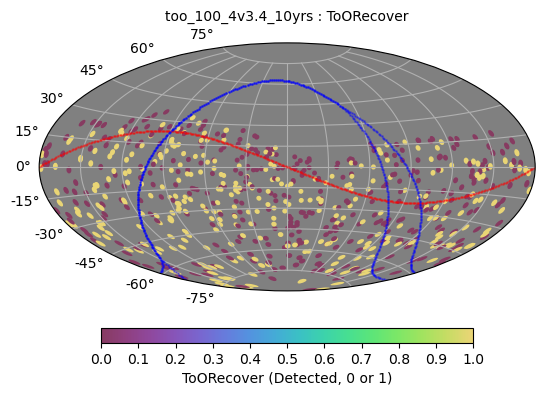

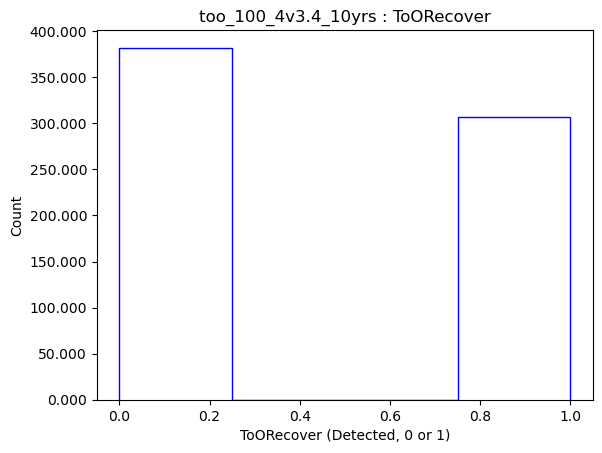

In [8]:
bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, db_file, out_dir=out_dir, results_db=results_db)
bg.run_all()
bg.plot_all(closefigs=False)

In [9]:
bundle_list[0].summary_values

{'Total detected': 307.0,
 'Total lightcurves in footprint': 689,
 'Total lightcurves on sky': 1000,
 'Fraction detected of total (mean)': 0.307}

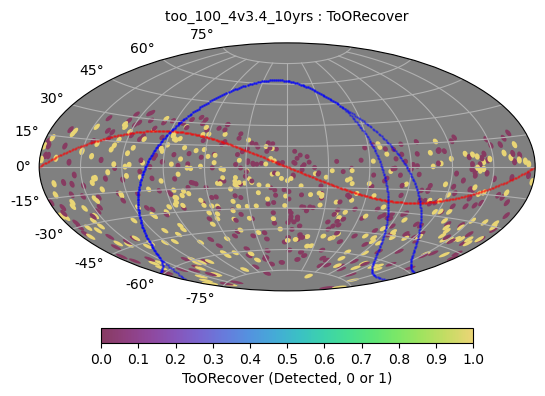

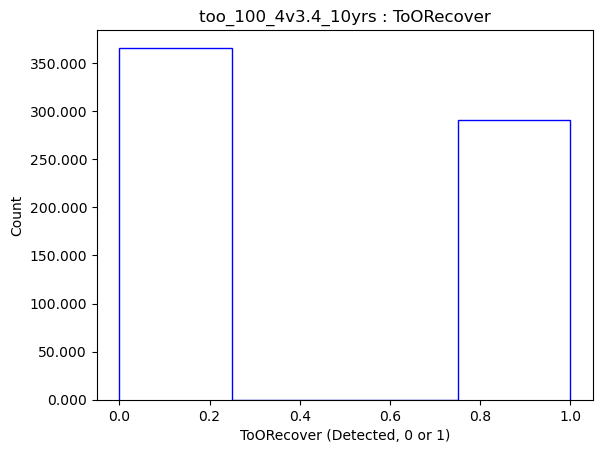

In [10]:
# run a few degrees North

bundle_list = []

new_dec = too_events["dec"].values + np.radians(4.)

new_dec[np.where(new_dec > np.pi/2)] -= np.pi/2

slicer = gen_too_slicer(too_events["mjd_start"].values, too_events["ra"].values, new_dec)
metric = TooRecoverMetric()

bundle = maf.MetricBundle(
        metric,
        slicer,
        "",
        run_name=run_name,
        summary_metrics=summary,
    )
bundle_list.append(bundle)

bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, db_file, out_dir=out_dir, results_db=results_db)
bg.run_all()
bg.plot_all(closefigs=False)


In [11]:
bundle_list[0].summary_values



{'Total detected': 291.0,
 'Total lightcurves in footprint': 657,
 'Total lightcurves on sky': 1000,
 'Fraction detected of total (mean)': 0.291}

In [12]:
# This is a little lower, but we preferentially shifted things out of the footprint, so I think this means we're fine
# and analyzing the spot of the ToO is good enough.